In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, auc
from tqdm import tqdm
import backbone
import sys
sys.path.append("..")
from dataloader import create_dataloader

# Set device to GPU if available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Current device: {torch.cuda.get_device_name(torch.cuda.current_device())}" if torch.cuda.is_available() else "Current device: CPU")

Current device: NVIDIA GeForce RTX 2080 Ti


In [2]:
# Define hyperparameters
batch_size = 16
num_epochs = 200
learning_rate = 0.00001
image_size = 384
num_workers = 4
num_labels = 20
thresholds = [0.5] * num_labels
num_classes = 20
data_dir = '../../mured-data/data'

In [3]:
# Create dataloaders
train_dataloader = create_dataloader(data_dir=data_dir, batch_size=batch_size, num_workers=num_workers, size=image_size, phase='train')
val_dataloader = create_dataloader(data_dir=data_dir, batch_size=batch_size, num_workers=num_workers, size=image_size, phase='val')

384
384


In [4]:
# # Create model and move to device
# model = backbone.backbone['densenet201'](num_classes=num_classes)
# model.to(device)

# # Define loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [4]:
# # Create model and move to device
# model = backbone.backbone['resnet152v2'](num_classes=num_classes)
# model.to(device)

# # Define loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [4]:
# Create model and move to device
model = backbone.backbone['efficientnetv2_extralarge'](num_classes=num_classes)
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
# create empty lists to store predicted probabilities and true labels for each epoch
train_preds_all, train_labels_all = [], []
val_preds_all, val_labels_all = [], []
# create a list to store the ROC plots
roc_plots = []

# define the epochs at which to plot the ROC curve
roc_epochs = [5,10,20,30,40,50,60,70,80,90,100,120,140,160,180,200]
#roc_epochs = [int(num_epochs / 4), int(num_epochs / 2), int(3 * num_epochs / 4), num_epochs]

# create empty lists to store ROC data for each epoch
roc_fpr = []
roc_tpr = []
roc_auc = []
f1_arr = []
loss_arr = []

# Training Loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    print('-' * 10)

    # Train phase
    model.train()
    running_loss = 0.0
    train_preds, train_labels = [], []
    for inputs, labels in tqdm(train_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels.float())
        loss.backward()

        optimizer.step()

        running_loss += loss.item()

        # append the predicted probabilities and true labels to lists for calculating ROC AUC score later
        train_preds += outputs.sigmoid().tolist()
        train_labels += labels.tolist()


    epoch_loss_train = running_loss / len(train_dataloader)
    print(f"Training Loss: {epoch_loss_train:.4f}")
    
    # calculate ROC AUC score for train set
    train_roc_auc = roc_auc_score(train_labels, train_preds)
    print(f"Train ROC AUC Score: {train_roc_auc:.4f}")
    
    # append the predicted probabilities and true labels for this epoch to the lists for all epochs
    train_preds_all.append(train_preds)
    train_labels_all.append(train_labels)

    # Validation phase
    model.eval()
    running_loss = 0.0
    val_preds, val_labels = [], []
    for inputs, labels in tqdm(val_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels.float())

            running_loss += loss.item()

        # append the predicted probabilities and true labels to lists for calculating ROC AUC score later
        val_preds += outputs.sigmoid().tolist()
        val_labels += labels.tolist()

    epoch_loss_val = running_loss / len(val_dataloader)
    print(f"Validation Loss: {epoch_loss_val:.4f}")

    # calculate ROC AUC score for validation set
    val_roc_auc = roc_auc_score(val_labels, val_preds)
    print(f"Validation ROC AUC Score: {val_roc_auc:.4f}")
    
    # append the predicted probabilities and true labels for this epoch to the lists for all epochs
    val_preds_all.append(val_preds)
    val_labels_all.append(val_labels)
    
    # calculate F1 score for validation set using the defined thresholds
    val_preds_thresholded = [[1 if pred[i] >= thresholds[i] else 0 for i in range(num_labels)] for pred in val_preds]
    val_f1_score = f1_score(val_labels, val_preds_thresholded, average='macro')
    print(f"Validation F1 Score: {val_f1_score:.4f}")
        
    f1_arr.append(val_f1_score)
    loss_arr.append(epoch_loss_val)
    
    # check if the current epoch is in the list of epochs to plot ROC curve
    if epoch+1 in roc_epochs:
        # calculate ROC curve and AUC score for validation set
        fpr, tpr, roc_thresholds = roc_curve(np.concatenate(val_labels_all).ravel(), np.concatenate(val_preds_all).ravel())
        roc_fpr.append(fpr)
        roc_tpr.append(tpr)
        roc_auc.append(auc(fpr, tpr))

    print() # empty line for spacing

Epoch 1/200
----------


100%|██████████| 111/111 [00:31<00:00,  3.52it/s]


Training Loss: 1.3885
Train ROC AUC Score: 0.9928


100%|██████████| 28/28 [00:09<00:00,  2.99it/s]


Validation Loss: 1.6947
Validation ROC AUC Score: 0.9322
Validation F1 Score: 0.2096

Epoch 2/200
----------


100%|██████████| 111/111 [00:34<00:00,  3.25it/s]


Training Loss: 1.3322
Train ROC AUC Score: 0.9931


100%|██████████| 28/28 [00:09<00:00,  2.97it/s]


Validation Loss: 1.7191
Validation ROC AUC Score: 0.9335
Validation F1 Score: 0.2112

Epoch 3/200
----------


100%|██████████| 111/111 [00:34<00:00,  3.23it/s]


Training Loss: 1.3893
Train ROC AUC Score: 0.9935


100%|██████████| 28/28 [00:09<00:00,  3.04it/s]


Validation Loss: 1.7005
Validation ROC AUC Score: 0.9342
Validation F1 Score: 0.2091

Epoch 4/200
----------


100%|██████████| 111/111 [00:34<00:00,  3.24it/s]


Training Loss: 1.3125
Train ROC AUC Score: 0.9935


100%|██████████| 28/28 [00:09<00:00,  2.98it/s]


Validation Loss: 1.6993
Validation ROC AUC Score: 0.9320
Validation F1 Score: 0.2119

Epoch 5/200
----------


100%|██████████| 111/111 [00:33<00:00,  3.31it/s]


Training Loss: 1.3432
Train ROC AUC Score: 0.9935


100%|██████████| 28/28 [00:09<00:00,  3.03it/s]


Validation Loss: 1.6905
Validation ROC AUC Score: 0.9327
Validation F1 Score: 0.2086

Epoch 6/200
----------


100%|██████████| 111/111 [00:33<00:00,  3.27it/s]


Training Loss: 1.2859
Train ROC AUC Score: 0.9949


100%|██████████| 28/28 [00:09<00:00,  2.95it/s]


Validation Loss: 1.6969
Validation ROC AUC Score: 0.9320
Validation F1 Score: 0.2113

Epoch 7/200
----------


100%|██████████| 111/111 [00:33<00:00,  3.35it/s]


Training Loss: 1.3031
Train ROC AUC Score: 0.9940


100%|██████████| 28/28 [00:09<00:00,  3.02it/s]


Validation Loss: 1.6832
Validation ROC AUC Score: 0.9306
Validation F1 Score: 0.2134

Epoch 8/200
----------


100%|██████████| 111/111 [00:33<00:00,  3.33it/s]


Training Loss: 1.3115
Train ROC AUC Score: 0.9945


100%|██████████| 28/28 [00:09<00:00,  3.03it/s]


Validation Loss: 1.7024
Validation ROC AUC Score: 0.9314
Validation F1 Score: 0.2121

Epoch 9/200
----------


100%|██████████| 111/111 [00:33<00:00,  3.35it/s]


Training Loss: 1.3276
Train ROC AUC Score: 0.9941


100%|██████████| 28/28 [00:09<00:00,  3.02it/s]


Validation Loss: 1.7123
Validation ROC AUC Score: 0.9290
Validation F1 Score: 0.2146

Epoch 10/200
----------


100%|██████████| 111/111 [00:34<00:00,  3.25it/s]


Training Loss: 1.3154
Train ROC AUC Score: 0.9947


100%|██████████| 28/28 [00:09<00:00,  3.06it/s]


Validation Loss: 1.6668
Validation ROC AUC Score: 0.9334
Validation F1 Score: 0.2093

Epoch 11/200
----------


100%|██████████| 111/111 [00:33<00:00,  3.29it/s]


Training Loss: 1.2903
Train ROC AUC Score: 0.9945


100%|██████████| 28/28 [00:09<00:00,  2.96it/s]


Validation Loss: 1.6607
Validation ROC AUC Score: 0.9326
Validation F1 Score: 0.2099

Epoch 12/200
----------


100%|██████████| 111/111 [00:33<00:00,  3.29it/s]


Training Loss: 1.2652
Train ROC AUC Score: 0.9941


100%|██████████| 28/28 [00:09<00:00,  3.00it/s]


Validation Loss: 1.6855
Validation ROC AUC Score: 0.9322
Validation F1 Score: 0.2109

Epoch 13/200
----------


100%|██████████| 111/111 [00:34<00:00,  3.24it/s]


Training Loss: 1.2726
Train ROC AUC Score: 0.9948


100%|██████████| 28/28 [00:09<00:00,  2.99it/s]


Validation Loss: 1.6718
Validation ROC AUC Score: 0.9295
Validation F1 Score: 0.2122

Epoch 14/200
----------


100%|██████████| 111/111 [00:32<00:00,  3.43it/s]


Training Loss: 1.3217
Train ROC AUC Score: 0.9946


100%|██████████| 28/28 [00:09<00:00,  3.01it/s]


Validation Loss: 1.6851
Validation ROC AUC Score: 0.9309
Validation F1 Score: 0.2134

Epoch 15/200
----------


100%|██████████| 111/111 [00:33<00:00,  3.30it/s]


Training Loss: 1.2922
Train ROC AUC Score: 0.9941


100%|██████████| 28/28 [00:09<00:00,  3.00it/s]


Validation Loss: 1.6698
Validation ROC AUC Score: 0.9338
Validation F1 Score: 0.2099

Epoch 16/200
----------


100%|██████████| 111/111 [00:32<00:00,  3.40it/s]


Training Loss: 1.3093
Train ROC AUC Score: 0.9956


100%|██████████| 28/28 [00:09<00:00,  2.98it/s]


Validation Loss: 1.6979
Validation ROC AUC Score: 0.9338
Validation F1 Score: 0.2117

Epoch 17/200
----------


100%|██████████| 111/111 [00:33<00:00,  3.34it/s]


Training Loss: 1.2623
Train ROC AUC Score: 0.9953


100%|██████████| 28/28 [00:09<00:00,  2.98it/s]


Validation Loss: 1.6632
Validation ROC AUC Score: 0.9328
Validation F1 Score: 0.2109

Epoch 18/200
----------


100%|██████████| 111/111 [00:32<00:00,  3.38it/s]


Training Loss: 1.2424
Train ROC AUC Score: 0.9956


100%|██████████| 28/28 [00:09<00:00,  2.92it/s]


Validation Loss: 1.6865
Validation ROC AUC Score: 0.9322
Validation F1 Score: 0.2160

Epoch 19/200
----------


100%|██████████| 111/111 [00:32<00:00,  3.42it/s]


Training Loss: 1.2919
Train ROC AUC Score: 0.9953


100%|██████████| 28/28 [00:09<00:00,  2.98it/s]


Validation Loss: 1.6588
Validation ROC AUC Score: 0.9328
Validation F1 Score: 0.2140

Epoch 20/200
----------


100%|██████████| 111/111 [00:32<00:00,  3.36it/s]


Training Loss: 1.2950
Train ROC AUC Score: 0.9958


100%|██████████| 28/28 [00:09<00:00,  2.98it/s]


Validation Loss: 1.6576
Validation ROC AUC Score: 0.9334
Validation F1 Score: 0.2116

Epoch 21/200
----------


100%|██████████| 111/111 [00:33<00:00,  3.31it/s]


Training Loss: 1.2472
Train ROC AUC Score: 0.9952


100%|██████████| 28/28 [00:09<00:00,  3.04it/s]


Validation Loss: 1.7130
Validation ROC AUC Score: 0.9311
Validation F1 Score: 0.2120

Epoch 22/200
----------


100%|██████████| 111/111 [00:34<00:00,  3.20it/s]


Training Loss: 1.2274
Train ROC AUC Score: 0.9954


100%|██████████| 28/28 [00:09<00:00,  2.94it/s]


Validation Loss: 1.6618
Validation ROC AUC Score: 0.9329
Validation F1 Score: 0.2123

Epoch 23/200
----------


100%|██████████| 111/111 [00:32<00:00,  3.37it/s]


Training Loss: 1.2486
Train ROC AUC Score: 0.9958


100%|██████████| 28/28 [00:09<00:00,  2.93it/s]


Validation Loss: 1.6713
Validation ROC AUC Score: 0.9327
Validation F1 Score: 0.2127

Epoch 24/200
----------


100%|██████████| 111/111 [00:33<00:00,  3.33it/s]


Training Loss: 1.2973
Train ROC AUC Score: 0.9961


100%|██████████| 28/28 [00:09<00:00,  3.02it/s]


Validation Loss: 1.7079
Validation ROC AUC Score: 0.9323
Validation F1 Score: 0.2135

Epoch 25/200
----------


100%|██████████| 111/111 [00:36<00:00,  3.07it/s]


Training Loss: 1.2122
Train ROC AUC Score: 0.9956


100%|██████████| 28/28 [00:09<00:00,  3.00it/s]


Validation Loss: 1.7045
Validation ROC AUC Score: 0.9308
Validation F1 Score: 0.2115

Epoch 26/200
----------


100%|██████████| 111/111 [00:33<00:00,  3.32it/s]


Training Loss: 1.2231
Train ROC AUC Score: 0.9958


100%|██████████| 28/28 [00:09<00:00,  2.95it/s]


Validation Loss: 1.7002
Validation ROC AUC Score: 0.9311
Validation F1 Score: 0.2074

Epoch 27/200
----------


100%|██████████| 111/111 [00:32<00:00,  3.43it/s]


Training Loss: 1.1899
Train ROC AUC Score: 0.9961


100%|██████████| 28/28 [00:09<00:00,  2.96it/s]


Validation Loss: 1.7032
Validation ROC AUC Score: 0.9296
Validation F1 Score: 0.2104

Epoch 28/200
----------


100%|██████████| 111/111 [00:32<00:00,  3.40it/s]


Training Loss: 1.2671
Train ROC AUC Score: 0.9954


100%|██████████| 28/28 [00:09<00:00,  3.01it/s]


Validation Loss: 1.7283
Validation ROC AUC Score: 0.9294
Validation F1 Score: 0.2140

Epoch 29/200
----------


100%|██████████| 111/111 [00:33<00:00,  3.35it/s]


Training Loss: 1.2256
Train ROC AUC Score: 0.9962


100%|██████████| 28/28 [00:09<00:00,  2.87it/s]


Validation Loss: 1.7141
Validation ROC AUC Score: 0.9299
Validation F1 Score: 0.2121

Epoch 30/200
----------


100%|██████████| 111/111 [00:33<00:00,  3.31it/s]


Training Loss: 1.1878
Train ROC AUC Score: 0.9958


100%|██████████| 28/28 [00:09<00:00,  3.00it/s]


Validation Loss: 1.6709
Validation ROC AUC Score: 0.9318
Validation F1 Score: 0.2123

Epoch 31/200
----------


100%|██████████| 111/111 [00:33<00:00,  3.27it/s]


Training Loss: 1.2878
Train ROC AUC Score: 0.9963


100%|██████████| 28/28 [00:09<00:00,  2.90it/s]


Validation Loss: 1.6900
Validation ROC AUC Score: 0.9305
Validation F1 Score: 0.2110

Epoch 32/200
----------


100%|██████████| 111/111 [00:33<00:00,  3.28it/s]


Training Loss: 1.2443
Train ROC AUC Score: 0.9962


100%|██████████| 28/28 [00:09<00:00,  3.00it/s]


Validation Loss: 1.6806
Validation ROC AUC Score: 0.9329
Validation F1 Score: 0.2122

Epoch 33/200
----------


100%|██████████| 111/111 [00:32<00:00,  3.40it/s]


Training Loss: 1.2362
Train ROC AUC Score: 0.9968


100%|██████████| 28/28 [00:09<00:00,  2.98it/s]


Validation Loss: 1.7015
Validation ROC AUC Score: 0.9322
Validation F1 Score: 0.2119

Epoch 34/200
----------


100%|██████████| 111/111 [00:33<00:00,  3.28it/s]


Training Loss: 1.1749
Train ROC AUC Score: 0.9967


100%|██████████| 28/28 [00:09<00:00,  2.99it/s]


Validation Loss: 1.7283
Validation ROC AUC Score: 0.9297
Validation F1 Score: 0.2140

Epoch 35/200
----------


100%|██████████| 111/111 [00:33<00:00,  3.27it/s]


Training Loss: 1.2651
Train ROC AUC Score: 0.9963


100%|██████████| 28/28 [00:09<00:00,  2.91it/s]


Validation Loss: 1.6935
Validation ROC AUC Score: 0.9326
Validation F1 Score: 0.2124

Epoch 36/200
----------


100%|██████████| 111/111 [00:32<00:00,  3.37it/s]


Training Loss: 1.1980
Train ROC AUC Score: 0.9966


100%|██████████| 28/28 [00:09<00:00,  2.98it/s]


Validation Loss: 1.7069
Validation ROC AUC Score: 0.9329
Validation F1 Score: 0.2118

Epoch 37/200
----------


100%|██████████| 111/111 [00:33<00:00,  3.32it/s]


Training Loss: 1.1971
Train ROC AUC Score: 0.9972


100%|██████████| 28/28 [00:09<00:00,  2.96it/s]


Validation Loss: 1.7038
Validation ROC AUC Score: 0.9328
Validation F1 Score: 0.2138

Epoch 38/200
----------


100%|██████████| 111/111 [00:35<00:00,  3.16it/s]


Training Loss: 1.1931
Train ROC AUC Score: 0.9969


100%|██████████| 28/28 [00:09<00:00,  3.05it/s]


Validation Loss: 1.7023
Validation ROC AUC Score: 0.9315
Validation F1 Score: 0.2134

Epoch 39/200
----------


100%|██████████| 111/111 [00:33<00:00,  3.32it/s]


Training Loss: 1.1880
Train ROC AUC Score: 0.9966


100%|██████████| 28/28 [00:09<00:00,  2.92it/s]


Validation Loss: 1.6944
Validation ROC AUC Score: 0.9318
Validation F1 Score: 0.2134

Epoch 40/200
----------


100%|██████████| 111/111 [00:32<00:00,  3.41it/s]


Training Loss: 1.1473
Train ROC AUC Score: 0.9973


100%|██████████| 28/28 [00:09<00:00,  3.02it/s]


Validation Loss: 1.7158
Validation ROC AUC Score: 0.9323
Validation F1 Score: 0.2131

Epoch 41/200
----------


100%|██████████| 111/111 [00:33<00:00,  3.27it/s]


Training Loss: 1.1477
Train ROC AUC Score: 0.9973


100%|██████████| 28/28 [00:09<00:00,  3.02it/s]


Validation Loss: 1.6809
Validation ROC AUC Score: 0.9309
Validation F1 Score: 0.2131

Epoch 42/200
----------


100%|██████████| 111/111 [00:33<00:00,  3.28it/s]


Training Loss: 1.1836
Train ROC AUC Score: 0.9968


100%|██████████| 28/28 [00:09<00:00,  2.96it/s]


Validation Loss: 1.7171
Validation ROC AUC Score: 0.9324
Validation F1 Score: 0.2148

Epoch 43/200
----------


100%|██████████| 111/111 [00:33<00:00,  3.28it/s]


Training Loss: 1.2037
Train ROC AUC Score: 0.9966


100%|██████████| 28/28 [00:09<00:00,  3.04it/s]


Validation Loss: 1.6634
Validation ROC AUC Score: 0.9326
Validation F1 Score: 0.2105

Epoch 44/200
----------


100%|██████████| 111/111 [00:34<00:00,  3.19it/s]


Training Loss: 1.1455
Train ROC AUC Score: 0.9972


100%|██████████| 28/28 [00:09<00:00,  2.86it/s]


Validation Loss: 1.6693
Validation ROC AUC Score: 0.9316
Validation F1 Score: 0.2117

Epoch 45/200
----------


100%|██████████| 111/111 [00:33<00:00,  3.32it/s]


Training Loss: 1.1769
Train ROC AUC Score: 0.9964


100%|██████████| 28/28 [00:09<00:00,  3.03it/s]


Validation Loss: 1.7193
Validation ROC AUC Score: 0.9314
Validation F1 Score: 0.2141

Epoch 46/200
----------


100%|██████████| 111/111 [00:35<00:00,  3.16it/s]


Training Loss: 1.1288
Train ROC AUC Score: 0.9975


100%|██████████| 28/28 [00:09<00:00,  3.07it/s]


Validation Loss: 1.6909
Validation ROC AUC Score: 0.9304
Validation F1 Score: 0.2108

Epoch 47/200
----------


100%|██████████| 111/111 [00:32<00:00,  3.38it/s]


Training Loss: 1.1029
Train ROC AUC Score: 0.9970


100%|██████████| 28/28 [00:09<00:00,  2.99it/s]


Validation Loss: 1.7138
Validation ROC AUC Score: 0.9316
Validation F1 Score: 0.2129

Epoch 48/200
----------


100%|██████████| 111/111 [00:33<00:00,  3.31it/s]


Training Loss: 1.1877
Train ROC AUC Score: 0.9970


100%|██████████| 28/28 [00:09<00:00,  2.99it/s]


Validation Loss: 1.7120
Validation ROC AUC Score: 0.9306
Validation F1 Score: 0.2116

Epoch 49/200
----------


100%|██████████| 111/111 [00:32<00:00,  3.38it/s]


Training Loss: 1.1801
Train ROC AUC Score: 0.9973


100%|██████████| 28/28 [00:09<00:00,  3.04it/s]


Validation Loss: 1.7422
Validation ROC AUC Score: 0.9302
Validation F1 Score: 0.2124

Epoch 50/200
----------


100%|██████████| 111/111 [00:33<00:00,  3.32it/s]


Training Loss: 1.1904
Train ROC AUC Score: 0.9972


100%|██████████| 28/28 [00:09<00:00,  3.02it/s]


Validation Loss: 1.7562
Validation ROC AUC Score: 0.9271
Validation F1 Score: 0.2116

Epoch 51/200
----------


100%|██████████| 111/111 [00:32<00:00,  3.39it/s]


Training Loss: 1.1925
Train ROC AUC Score: 0.9967


100%|██████████| 28/28 [00:09<00:00,  2.93it/s]


Validation Loss: 1.7091
Validation ROC AUC Score: 0.9303
Validation F1 Score: 0.2121

Epoch 52/200
----------


100%|██████████| 111/111 [00:33<00:00,  3.32it/s]


Training Loss: 1.1986
Train ROC AUC Score: 0.9973


100%|██████████| 28/28 [00:09<00:00,  3.03it/s]


Validation Loss: 1.7102
Validation ROC AUC Score: 0.9301
Validation F1 Score: 0.2106

Epoch 53/200
----------


100%|██████████| 111/111 [00:35<00:00,  3.15it/s]


Training Loss: 1.1939
Train ROC AUC Score: 0.9971


100%|██████████| 28/28 [00:09<00:00,  2.95it/s]


Validation Loss: 1.7228
Validation ROC AUC Score: 0.9291
Validation F1 Score: 0.2158

Epoch 54/200
----------


100%|██████████| 111/111 [00:32<00:00,  3.39it/s]


Training Loss: 1.1272
Train ROC AUC Score: 0.9972


100%|██████████| 28/28 [00:09<00:00,  2.97it/s]


Validation Loss: 1.7065
Validation ROC AUC Score: 0.9299
Validation F1 Score: 0.2134

Epoch 55/200
----------


100%|██████████| 111/111 [00:33<00:00,  3.30it/s]


Training Loss: 1.1556
Train ROC AUC Score: 0.9971


100%|██████████| 28/28 [00:09<00:00,  3.07it/s]


Validation Loss: 1.7018
Validation ROC AUC Score: 0.9305
Validation F1 Score: 0.2136

Epoch 56/200
----------


100%|██████████| 111/111 [00:34<00:00,  3.26it/s]


Training Loss: 1.1889
Train ROC AUC Score: 0.9966


100%|██████████| 28/28 [00:09<00:00,  3.00it/s]


Validation Loss: 1.6964
Validation ROC AUC Score: 0.9312
Validation F1 Score: 0.2105

Epoch 57/200
----------


100%|██████████| 111/111 [00:34<00:00,  3.24it/s]


Training Loss: 1.1532
Train ROC AUC Score: 0.9973


100%|██████████| 28/28 [00:09<00:00,  2.91it/s]


Validation Loss: 1.7148
Validation ROC AUC Score: 0.9310
Validation F1 Score: 0.2119

Epoch 58/200
----------


100%|██████████| 111/111 [00:35<00:00,  3.17it/s]


Training Loss: 1.1233
Train ROC AUC Score: 0.9980


100%|██████████| 28/28 [00:09<00:00,  2.91it/s]


Validation Loss: 1.6634
Validation ROC AUC Score: 0.9322
Validation F1 Score: 0.2106

Epoch 59/200
----------


100%|██████████| 111/111 [00:33<00:00,  3.36it/s]


Training Loss: 1.1271
Train ROC AUC Score: 0.9977


100%|██████████| 28/28 [00:09<00:00,  2.89it/s]


Validation Loss: 1.7005
Validation ROC AUC Score: 0.9312
Validation F1 Score: 0.2099

Epoch 60/200
----------


100%|██████████| 111/111 [00:34<00:00,  3.23it/s]


Training Loss: 1.0860
Train ROC AUC Score: 0.9976


100%|██████████| 28/28 [00:09<00:00,  2.85it/s]


Validation Loss: 1.7530
Validation ROC AUC Score: 0.9273
Validation F1 Score: 0.2148

Epoch 61/200
----------


100%|██████████| 111/111 [00:33<00:00,  3.33it/s]


Training Loss: 1.1116
Train ROC AUC Score: 0.9978


100%|██████████| 28/28 [00:09<00:00,  2.93it/s]


Validation Loss: 1.7164
Validation ROC AUC Score: 0.9290
Validation F1 Score: 0.2130

Epoch 62/200
----------


100%|██████████| 111/111 [00:33<00:00,  3.28it/s]


Training Loss: 1.1909
Train ROC AUC Score: 0.9975


100%|██████████| 28/28 [00:09<00:00,  2.99it/s]


Validation Loss: 1.7079
Validation ROC AUC Score: 0.9323
Validation F1 Score: 0.2135

Epoch 63/200
----------


100%|██████████| 111/111 [00:34<00:00,  3.25it/s]


Training Loss: 1.1640
Train ROC AUC Score: 0.9966


100%|██████████| 28/28 [00:09<00:00,  2.89it/s]


Validation Loss: 1.6625
Validation ROC AUC Score: 0.9296
Validation F1 Score: 0.2121

Epoch 64/200
----------


100%|██████████| 111/111 [00:32<00:00,  3.37it/s]


Training Loss: 1.2162
Train ROC AUC Score: 0.9972


100%|██████████| 28/28 [00:09<00:00,  3.11it/s]


Validation Loss: 1.7072
Validation ROC AUC Score: 0.9302
Validation F1 Score: 0.2138

Epoch 65/200
----------


100%|██████████| 111/111 [00:32<00:00,  3.41it/s]


Training Loss: 1.1159
Train ROC AUC Score: 0.9975


100%|██████████| 28/28 [00:09<00:00,  3.07it/s]


Validation Loss: 1.7043
Validation ROC AUC Score: 0.9293
Validation F1 Score: 0.2097

Epoch 66/200
----------


100%|██████████| 111/111 [00:32<00:00,  3.37it/s]


Training Loss: 1.1900
Train ROC AUC Score: 0.9967


100%|██████████| 28/28 [00:09<00:00,  3.04it/s]


Validation Loss: 1.7316
Validation ROC AUC Score: 0.9291
Validation F1 Score: 0.2148

Epoch 67/200
----------


100%|██████████| 111/111 [00:32<00:00,  3.38it/s]


Training Loss: 1.1666
Train ROC AUC Score: 0.9973


100%|██████████| 28/28 [00:09<00:00,  2.96it/s]


Validation Loss: 1.7138
Validation ROC AUC Score: 0.9297
Validation F1 Score: 0.2116

Epoch 68/200
----------


100%|██████████| 111/111 [00:33<00:00,  3.33it/s]


Training Loss: 1.1520
Train ROC AUC Score: 0.9975


100%|██████████| 28/28 [00:09<00:00,  3.03it/s]


Validation Loss: 1.7345
Validation ROC AUC Score: 0.9294
Validation F1 Score: 0.2117

Epoch 69/200
----------


100%|██████████| 111/111 [00:32<00:00,  3.40it/s]


Training Loss: 1.1541
Train ROC AUC Score: 0.9972


100%|██████████| 28/28 [00:09<00:00,  3.00it/s]


Validation Loss: 1.7140
Validation ROC AUC Score: 0.9312
Validation F1 Score: 0.2151

Epoch 70/200
----------


100%|██████████| 111/111 [00:32<00:00,  3.39it/s]


Training Loss: 1.1679
Train ROC AUC Score: 0.9975


100%|██████████| 28/28 [00:09<00:00,  3.02it/s]


Validation Loss: 1.7311
Validation ROC AUC Score: 0.9311
Validation F1 Score: 0.2125

Epoch 71/200
----------


100%|██████████| 111/111 [00:33<00:00,  3.33it/s]


Training Loss: 1.1497
Train ROC AUC Score: 0.9974


100%|██████████| 28/28 [00:09<00:00,  3.08it/s]


Validation Loss: 1.7204
Validation ROC AUC Score: 0.9314
Validation F1 Score: 0.2155

Epoch 72/200
----------


100%|██████████| 111/111 [00:32<00:00,  3.45it/s]


Training Loss: 1.0860
Train ROC AUC Score: 0.9975


100%|██████████| 28/28 [00:09<00:00,  2.98it/s]


Validation Loss: 1.7695
Validation ROC AUC Score: 0.9288
Validation F1 Score: 0.2208

Epoch 73/200
----------


100%|██████████| 111/111 [00:32<00:00,  3.39it/s]


Training Loss: 1.0934
Train ROC AUC Score: 0.9975


100%|██████████| 28/28 [00:09<00:00,  3.02it/s]


Validation Loss: 1.7407
Validation ROC AUC Score: 0.9264
Validation F1 Score: 0.2158

Epoch 74/200
----------


100%|██████████| 111/111 [00:32<00:00,  3.40it/s]


Training Loss: 1.1399
Train ROC AUC Score: 0.9979


100%|██████████| 28/28 [00:09<00:00,  3.06it/s]


Validation Loss: 1.7298
Validation ROC AUC Score: 0.9308
Validation F1 Score: 0.2157

Epoch 75/200
----------


100%|██████████| 111/111 [00:34<00:00,  3.23it/s]


Training Loss: 1.0213
Train ROC AUC Score: 0.9979


100%|██████████| 28/28 [00:09<00:00,  3.00it/s]


Validation Loss: 1.7118
Validation ROC AUC Score: 0.9304
Validation F1 Score: 0.2135

Epoch 76/200
----------


100%|██████████| 111/111 [00:32<00:00,  3.37it/s]


Training Loss: 1.1860
Train ROC AUC Score: 0.9980


100%|██████████| 28/28 [00:09<00:00,  2.89it/s]


Validation Loss: 1.7198
Validation ROC AUC Score: 0.9292
Validation F1 Score: 0.2147

Epoch 77/200
----------


100%|██████████| 111/111 [00:35<00:00,  3.16it/s]


Training Loss: 1.0782
Train ROC AUC Score: 0.9976


100%|██████████| 28/28 [00:09<00:00,  3.02it/s]


Validation Loss: 1.7255
Validation ROC AUC Score: 0.9284
Validation F1 Score: 0.2136

Epoch 78/200
----------


100%|██████████| 111/111 [00:32<00:00,  3.46it/s]


Training Loss: 1.0504
Train ROC AUC Score: 0.9983


100%|██████████| 28/28 [00:09<00:00,  2.93it/s]


Validation Loss: 1.7637
Validation ROC AUC Score: 0.9292
Validation F1 Score: 0.2128

Epoch 79/200
----------


100%|██████████| 111/111 [00:33<00:00,  3.30it/s]


Training Loss: 1.1302
Train ROC AUC Score: 0.9979


100%|██████████| 28/28 [00:09<00:00,  2.80it/s]


Validation Loss: 1.7390
Validation ROC AUC Score: 0.9272
Validation F1 Score: 0.2192

Epoch 80/200
----------


100%|██████████| 111/111 [00:35<00:00,  3.15it/s]


Training Loss: 1.0457
Train ROC AUC Score: 0.9976


100%|██████████| 28/28 [00:09<00:00,  2.94it/s]


Validation Loss: 1.7225
Validation ROC AUC Score: 0.9312
Validation F1 Score: 0.2135

Epoch 81/200
----------


100%|██████████| 111/111 [00:33<00:00,  3.31it/s]


Training Loss: 1.1198
Train ROC AUC Score: 0.9976


100%|██████████| 28/28 [00:09<00:00,  3.00it/s]


Validation Loss: 1.7319
Validation ROC AUC Score: 0.9303
Validation F1 Score: 0.2111

Epoch 82/200
----------


100%|██████████| 111/111 [00:34<00:00,  3.19it/s]


Training Loss: 1.1063
Train ROC AUC Score: 0.9979


100%|██████████| 28/28 [00:09<00:00,  2.97it/s]


Validation Loss: 1.6956
Validation ROC AUC Score: 0.9309
Validation F1 Score: 0.2140

Epoch 83/200
----------


100%|██████████| 111/111 [00:33<00:00,  3.35it/s]


Training Loss: 1.0921
Train ROC AUC Score: 0.9981


100%|██████████| 28/28 [00:09<00:00,  2.97it/s]


Validation Loss: 1.7565
Validation ROC AUC Score: 0.9289
Validation F1 Score: 0.2105

Epoch 84/200
----------


100%|██████████| 111/111 [00:34<00:00,  3.25it/s]


Training Loss: 1.1283
Train ROC AUC Score: 0.9974


100%|██████████| 28/28 [00:09<00:00,  3.06it/s]


Validation Loss: 1.7276
Validation ROC AUC Score: 0.9277
Validation F1 Score: 0.2153

Epoch 85/200
----------


100%|██████████| 111/111 [00:34<00:00,  3.21it/s]


Training Loss: 1.1269
Train ROC AUC Score: 0.9980


100%|██████████| 28/28 [00:09<00:00,  3.07it/s]


Validation Loss: 1.7292
Validation ROC AUC Score: 0.9278
Validation F1 Score: 0.2155

Epoch 86/200
----------


100%|██████████| 111/111 [00:33<00:00,  3.32it/s]


Training Loss: 1.0984
Train ROC AUC Score: 0.9981


100%|██████████| 28/28 [00:09<00:00,  3.10it/s]


Validation Loss: 1.7261
Validation ROC AUC Score: 0.9263
Validation F1 Score: 0.2086

Epoch 87/200
----------


100%|██████████| 111/111 [00:36<00:00,  3.07it/s]


Training Loss: 1.1544
Train ROC AUC Score: 0.9978


100%|██████████| 28/28 [00:09<00:00,  3.06it/s]


Validation Loss: 1.7137
Validation ROC AUC Score: 0.9307
Validation F1 Score: 0.2095

Epoch 88/200
----------


100%|██████████| 111/111 [00:32<00:00,  3.38it/s]


Training Loss: 1.1709
Train ROC AUC Score: 0.9978


100%|██████████| 28/28 [00:09<00:00,  2.96it/s]


Validation Loss: 1.7616
Validation ROC AUC Score: 0.9280
Validation F1 Score: 0.2124

Epoch 89/200
----------


100%|██████████| 111/111 [00:34<00:00,  3.25it/s]


Training Loss: 1.1044
Train ROC AUC Score: 0.9979


100%|██████████| 28/28 [00:09<00:00,  2.96it/s]


Validation Loss: 1.6985
Validation ROC AUC Score: 0.9298
Validation F1 Score: 0.2118

Epoch 90/200
----------


100%|██████████| 111/111 [00:34<00:00,  3.25it/s]


Training Loss: 1.0709
Train ROC AUC Score: 0.9979


100%|██████████| 28/28 [00:09<00:00,  2.98it/s]


Validation Loss: 1.7323
Validation ROC AUC Score: 0.9280
Validation F1 Score: 0.2132

Epoch 91/200
----------


100%|██████████| 111/111 [00:34<00:00,  3.19it/s]


Training Loss: 1.0831
Train ROC AUC Score: 0.9980


100%|██████████| 28/28 [00:09<00:00,  2.96it/s]


Validation Loss: 1.7007
Validation ROC AUC Score: 0.9320
Validation F1 Score: 0.2156

Epoch 92/200
----------


100%|██████████| 111/111 [00:33<00:00,  3.31it/s]


Training Loss: 1.0916
Train ROC AUC Score: 0.9979


100%|██████████| 28/28 [00:09<00:00,  2.98it/s]


Validation Loss: 1.7148
Validation ROC AUC Score: 0.9312
Validation F1 Score: 0.2169

Epoch 93/200
----------


100%|██████████| 111/111 [00:32<00:00,  3.38it/s]


Training Loss: 1.0867
Train ROC AUC Score: 0.9983


100%|██████████| 28/28 [00:09<00:00,  3.03it/s]


Validation Loss: 1.7159
Validation ROC AUC Score: 0.9299
Validation F1 Score: 0.2128

Epoch 94/200
----------


100%|██████████| 111/111 [00:33<00:00,  3.32it/s]


Training Loss: 1.1226
Train ROC AUC Score: 0.9978


100%|██████████| 28/28 [00:10<00:00,  2.61it/s]


Validation Loss: 1.7296
Validation ROC AUC Score: 0.9278
Validation F1 Score: 0.2172

Epoch 95/200
----------


100%|██████████| 111/111 [00:32<00:00,  3.38it/s]


Training Loss: 1.0431
Train ROC AUC Score: 0.9987


100%|██████████| 28/28 [00:09<00:00,  2.96it/s]


Validation Loss: 1.7452
Validation ROC AUC Score: 0.9280
Validation F1 Score: 0.2162

Epoch 96/200
----------


100%|██████████| 111/111 [00:32<00:00,  3.38it/s]


Training Loss: 1.1118
Train ROC AUC Score: 0.9981


100%|██████████| 28/28 [00:09<00:00,  3.00it/s]


Validation Loss: 1.7065
Validation ROC AUC Score: 0.9299
Validation F1 Score: 0.2090

Epoch 97/200
----------


100%|██████████| 111/111 [00:34<00:00,  3.22it/s]


Training Loss: 1.0948
Train ROC AUC Score: 0.9983


100%|██████████| 28/28 [00:09<00:00,  2.90it/s]


Validation Loss: 1.7218
Validation ROC AUC Score: 0.9306
Validation F1 Score: 0.2146

Epoch 98/200
----------


100%|██████████| 111/111 [00:34<00:00,  3.20it/s]


Training Loss: 1.1248
Train ROC AUC Score: 0.9980


100%|██████████| 28/28 [00:09<00:00,  2.88it/s]


Validation Loss: 1.7034
Validation ROC AUC Score: 0.9309
Validation F1 Score: 0.2145

Epoch 99/200
----------


100%|██████████| 111/111 [00:34<00:00,  3.22it/s]


Training Loss: 1.1349
Train ROC AUC Score: 0.9980


100%|██████████| 28/28 [00:09<00:00,  2.86it/s]


Validation Loss: 1.7489
Validation ROC AUC Score: 0.9307
Validation F1 Score: 0.2182

Epoch 100/200
----------


100%|██████████| 111/111 [00:34<00:00,  3.24it/s]


Training Loss: 1.1139
Train ROC AUC Score: 0.9983


100%|██████████| 28/28 [00:09<00:00,  2.85it/s]


Validation Loss: 1.7449
Validation ROC AUC Score: 0.9285
Validation F1 Score: 0.2127

Epoch 101/200
----------


100%|██████████| 111/111 [00:33<00:00,  3.32it/s]


Training Loss: 1.0817
Train ROC AUC Score: 0.9982


100%|██████████| 28/28 [00:09<00:00,  2.90it/s]


Validation Loss: 1.7125
Validation ROC AUC Score: 0.9314
Validation F1 Score: 0.2118

Epoch 102/200
----------


100%|██████████| 111/111 [00:35<00:00,  3.14it/s]


Training Loss: 1.0328
Train ROC AUC Score: 0.9982


100%|██████████| 28/28 [00:09<00:00,  2.92it/s]


Validation Loss: 1.7494
Validation ROC AUC Score: 0.9278
Validation F1 Score: 0.2159

Epoch 103/200
----------


100%|██████████| 111/111 [00:32<00:00,  3.36it/s]


Training Loss: 1.0692
Train ROC AUC Score: 0.9984


100%|██████████| 28/28 [00:09<00:00,  2.94it/s]


Validation Loss: 1.7316
Validation ROC AUC Score: 0.9297
Validation F1 Score: 0.2172

Epoch 104/200
----------


100%|██████████| 111/111 [00:34<00:00,  3.26it/s]


Training Loss: 1.0778
Train ROC AUC Score: 0.9981


100%|██████████| 28/28 [00:09<00:00,  2.84it/s]


Validation Loss: 1.7265
Validation ROC AUC Score: 0.9306
Validation F1 Score: 0.2104

Epoch 105/200
----------


100%|██████████| 111/111 [00:32<00:00,  3.37it/s]


Training Loss: 1.1195
Train ROC AUC Score: 0.9980


100%|██████████| 28/28 [00:10<00:00,  2.67it/s]


Validation Loss: 1.7463
Validation ROC AUC Score: 0.9318
Validation F1 Score: 0.2142

Epoch 106/200
----------


100%|██████████| 111/111 [00:33<00:00,  3.29it/s]


Training Loss: 1.0579
Train ROC AUC Score: 0.9981


100%|██████████| 28/28 [00:09<00:00,  3.02it/s]


Validation Loss: 1.7034
Validation ROC AUC Score: 0.9299
Validation F1 Score: 0.2129

Epoch 107/200
----------


100%|██████████| 111/111 [00:34<00:00,  3.19it/s]


Training Loss: 1.1094
Train ROC AUC Score: 0.9981


100%|██████████| 28/28 [00:09<00:00,  3.03it/s]


Validation Loss: 1.7028
Validation ROC AUC Score: 0.9324
Validation F1 Score: 0.2146

Epoch 108/200
----------


100%|██████████| 111/111 [00:33<00:00,  3.29it/s]


Training Loss: 1.0881
Train ROC AUC Score: 0.9980


100%|██████████| 28/28 [00:09<00:00,  3.01it/s]


Validation Loss: 1.7275
Validation ROC AUC Score: 0.9296
Validation F1 Score: 0.2170

Epoch 109/200
----------


100%|██████████| 111/111 [00:33<00:00,  3.29it/s]


Training Loss: 1.0852
Train ROC AUC Score: 0.9984


100%|██████████| 28/28 [00:09<00:00,  2.91it/s]


Validation Loss: 1.6982
Validation ROC AUC Score: 0.9307
Validation F1 Score: 0.2145

Epoch 110/200
----------


100%|██████████| 111/111 [00:34<00:00,  3.21it/s]


Training Loss: 1.1168
Train ROC AUC Score: 0.9980


100%|██████████| 28/28 [00:09<00:00,  2.98it/s]


Validation Loss: 1.7359
Validation ROC AUC Score: 0.9312
Validation F1 Score: 0.2136

Epoch 111/200
----------


100%|██████████| 111/111 [00:34<00:00,  3.19it/s]


Training Loss: 1.0721
Train ROC AUC Score: 0.9980


100%|██████████| 28/28 [00:09<00:00,  3.01it/s]


Validation Loss: 1.7417
Validation ROC AUC Score: 0.9315
Validation F1 Score: 0.2115

Epoch 112/200
----------


100%|██████████| 111/111 [00:33<00:00,  3.30it/s]


Training Loss: 1.0517
Train ROC AUC Score: 0.9985


100%|██████████| 28/28 [00:09<00:00,  2.99it/s]


Validation Loss: 1.7720
Validation ROC AUC Score: 0.9291
Validation F1 Score: 0.2148

Epoch 113/200
----------


100%|██████████| 111/111 [00:32<00:00,  3.42it/s]


Training Loss: 1.0351
Train ROC AUC Score: 0.9986


100%|██████████| 28/28 [00:09<00:00,  3.05it/s]


Validation Loss: 1.7040
Validation ROC AUC Score: 0.9307
Validation F1 Score: 0.2176

Epoch 114/200
----------


100%|██████████| 111/111 [00:33<00:00,  3.33it/s]


Training Loss: 1.0524
Train ROC AUC Score: 0.9983


100%|██████████| 28/28 [00:09<00:00,  3.08it/s]


Validation Loss: 1.7232
Validation ROC AUC Score: 0.9298
Validation F1 Score: 0.2136

Epoch 115/200
----------


100%|██████████| 111/111 [00:33<00:00,  3.28it/s]


Training Loss: 1.0505
Train ROC AUC Score: 0.9979


100%|██████████| 28/28 [00:09<00:00,  3.00it/s]


Validation Loss: 1.7331
Validation ROC AUC Score: 0.9315
Validation F1 Score: 0.2136

Epoch 116/200
----------


100%|██████████| 111/111 [00:33<00:00,  3.35it/s]


Training Loss: 1.0810
Train ROC AUC Score: 0.9983


100%|██████████| 28/28 [00:09<00:00,  2.81it/s]


Validation Loss: 1.7033
Validation ROC AUC Score: 0.9327
Validation F1 Score: 0.2143

Epoch 117/200
----------


100%|██████████| 111/111 [00:33<00:00,  3.34it/s]


Training Loss: 1.0977
Train ROC AUC Score: 0.9984


100%|██████████| 28/28 [00:09<00:00,  2.87it/s]


Validation Loss: 1.7327
Validation ROC AUC Score: 0.9298
Validation F1 Score: 0.2145

Epoch 118/200
----------


100%|██████████| 111/111 [00:34<00:00,  3.21it/s]


Training Loss: 1.0743
Train ROC AUC Score: 0.9983


100%|██████████| 28/28 [00:09<00:00,  2.90it/s]


Validation Loss: 1.7308
Validation ROC AUC Score: 0.9325
Validation F1 Score: 0.2143

Epoch 119/200
----------


100%|██████████| 111/111 [00:33<00:00,  3.27it/s]


Training Loss: 1.0472
Train ROC AUC Score: 0.9983


100%|██████████| 28/28 [00:09<00:00,  2.94it/s]


Validation Loss: 1.7771
Validation ROC AUC Score: 0.9298
Validation F1 Score: 0.2108

Epoch 120/200
----------


100%|██████████| 111/111 [00:35<00:00,  3.17it/s]


Training Loss: 1.0354
Train ROC AUC Score: 0.9979


100%|██████████| 28/28 [00:10<00:00,  2.69it/s]


Validation Loss: 1.7392
Validation ROC AUC Score: 0.9299
Validation F1 Score: 0.2161

Epoch 121/200
----------


100%|██████████| 111/111 [00:33<00:00,  3.29it/s]


Training Loss: 1.1379
Train ROC AUC Score: 0.9983


100%|██████████| 28/28 [00:09<00:00,  2.90it/s]


Validation Loss: 1.7966
Validation ROC AUC Score: 0.9282
Validation F1 Score: 0.2159

Epoch 122/200
----------


100%|██████████| 111/111 [00:34<00:00,  3.20it/s]


Training Loss: 1.0202
Train ROC AUC Score: 0.9985


100%|██████████| 28/28 [00:09<00:00,  2.87it/s]


Validation Loss: 1.7728
Validation ROC AUC Score: 0.9309
Validation F1 Score: 0.2174

Epoch 123/200
----------


100%|██████████| 111/111 [00:34<00:00,  3.17it/s]


Training Loss: 1.0617
Train ROC AUC Score: 0.9985


100%|██████████| 28/28 [00:10<00:00,  2.67it/s]


Validation Loss: 1.7669
Validation ROC AUC Score: 0.9306
Validation F1 Score: 0.2151

Epoch 124/200
----------


100%|██████████| 111/111 [00:34<00:00,  3.17it/s]


Training Loss: 1.0528
Train ROC AUC Score: 0.9984


100%|██████████| 28/28 [00:09<00:00,  2.90it/s]


Validation Loss: 1.7970
Validation ROC AUC Score: 0.9304
Validation F1 Score: 0.2118

Epoch 125/200
----------


100%|██████████| 111/111 [00:35<00:00,  3.12it/s]


Training Loss: 1.0217
Train ROC AUC Score: 0.9986


100%|██████████| 28/28 [00:09<00:00,  2.87it/s]


Validation Loss: 1.7365
Validation ROC AUC Score: 0.9326
Validation F1 Score: 0.2157

Epoch 126/200
----------


100%|██████████| 111/111 [00:34<00:00,  3.22it/s]


Training Loss: 1.0558
Train ROC AUC Score: 0.9984


100%|██████████| 28/28 [00:09<00:00,  2.97it/s]


Validation Loss: 1.7693
Validation ROC AUC Score: 0.9302
Validation F1 Score: 0.2133

Epoch 127/200
----------


100%|██████████| 111/111 [00:34<00:00,  3.20it/s]


Training Loss: 1.0806
Train ROC AUC Score: 0.9984


100%|██████████| 28/28 [00:09<00:00,  2.91it/s]


Validation Loss: 1.7263
Validation ROC AUC Score: 0.9310
Validation F1 Score: 0.2151

Epoch 128/200
----------


100%|██████████| 111/111 [00:34<00:00,  3.19it/s]


Training Loss: 1.0366
Train ROC AUC Score: 0.9983


100%|██████████| 28/28 [00:09<00:00,  3.03it/s]


Validation Loss: 1.8246
Validation ROC AUC Score: 0.9306
Validation F1 Score: 0.2130

Epoch 129/200
----------


100%|██████████| 111/111 [00:35<00:00,  3.08it/s]


Training Loss: 1.0467
Train ROC AUC Score: 0.9983


100%|██████████| 28/28 [00:09<00:00,  3.02it/s]


Validation Loss: 1.8173
Validation ROC AUC Score: 0.9296
Validation F1 Score: 0.2154

Epoch 130/200
----------


100%|██████████| 111/111 [00:33<00:00,  3.34it/s]


Training Loss: 1.0781
Train ROC AUC Score: 0.9983


100%|██████████| 28/28 [00:09<00:00,  3.01it/s]


Validation Loss: 1.7809
Validation ROC AUC Score: 0.9330
Validation F1 Score: 0.2121

Epoch 131/200
----------


100%|██████████| 111/111 [00:34<00:00,  3.22it/s]


Training Loss: 1.0370
Train ROC AUC Score: 0.9981


100%|██████████| 28/28 [00:09<00:00,  2.99it/s]


Validation Loss: 1.8184
Validation ROC AUC Score: 0.9322
Validation F1 Score: 0.2141

Epoch 132/200
----------


100%|██████████| 111/111 [00:33<00:00,  3.29it/s]


Training Loss: 1.0546
Train ROC AUC Score: 0.9986


100%|██████████| 28/28 [00:09<00:00,  2.97it/s]


Validation Loss: 1.8081
Validation ROC AUC Score: 0.9323
Validation F1 Score: 0.2144

Epoch 133/200
----------


100%|██████████| 111/111 [00:32<00:00,  3.38it/s]


Training Loss: 1.0786
Train ROC AUC Score: 0.9985


100%|██████████| 28/28 [00:09<00:00,  3.05it/s]


Validation Loss: 1.7952
Validation ROC AUC Score: 0.9306
Validation F1 Score: 0.2140

Epoch 134/200
----------


100%|██████████| 111/111 [00:33<00:00,  3.34it/s]


Training Loss: 1.0484
Train ROC AUC Score: 0.9984


100%|██████████| 28/28 [00:09<00:00,  2.97it/s]


Validation Loss: 1.7777
Validation ROC AUC Score: 0.9310
Validation F1 Score: 0.2181

Epoch 135/200
----------


100%|██████████| 111/111 [00:33<00:00,  3.34it/s]


Training Loss: 1.1161
Train ROC AUC Score: 0.9984


100%|██████████| 28/28 [00:09<00:00,  2.97it/s]


Validation Loss: 1.7871
Validation ROC AUC Score: 0.9309
Validation F1 Score: 0.2085

Epoch 136/200
----------


100%|██████████| 111/111 [00:33<00:00,  3.30it/s]


Training Loss: 1.0219
Train ROC AUC Score: 0.9985


100%|██████████| 28/28 [00:09<00:00,  2.99it/s]


Validation Loss: 1.7495
Validation ROC AUC Score: 0.9313
Validation F1 Score: 0.2123

Epoch 137/200
----------


100%|██████████| 111/111 [00:32<00:00,  3.39it/s]


Training Loss: 1.0530
Train ROC AUC Score: 0.9985


100%|██████████| 28/28 [00:09<00:00,  3.05it/s]


Validation Loss: 1.7963
Validation ROC AUC Score: 0.9304
Validation F1 Score: 0.2151

Epoch 138/200
----------


100%|██████████| 111/111 [00:32<00:00,  3.37it/s]


Training Loss: 1.0591
Train ROC AUC Score: 0.9984


100%|██████████| 28/28 [00:09<00:00,  2.98it/s]


Validation Loss: 1.8076
Validation ROC AUC Score: 0.9292
Validation F1 Score: 0.2128

Epoch 139/200
----------


100%|██████████| 111/111 [00:32<00:00,  3.44it/s]


Training Loss: 1.0302
Train ROC AUC Score: 0.9981


100%|██████████| 28/28 [00:09<00:00,  3.03it/s]


Validation Loss: 1.7952
Validation ROC AUC Score: 0.9288
Validation F1 Score: 0.2141

Epoch 140/200
----------


100%|██████████| 111/111 [00:32<00:00,  3.37it/s]


Training Loss: 1.0981
Train ROC AUC Score: 0.9981


100%|██████████| 28/28 [00:09<00:00,  3.02it/s]


Validation Loss: 1.7615
Validation ROC AUC Score: 0.9325
Validation F1 Score: 0.2136

Epoch 141/200
----------


100%|██████████| 111/111 [00:33<00:00,  3.30it/s]


Training Loss: 1.0591
Train ROC AUC Score: 0.9984


100%|██████████| 28/28 [00:09<00:00,  3.03it/s]


Validation Loss: 1.7539
Validation ROC AUC Score: 0.9305
Validation F1 Score: 0.2131

Epoch 142/200
----------


100%|██████████| 111/111 [00:32<00:00,  3.44it/s]


Training Loss: 1.0688
Train ROC AUC Score: 0.9980


100%|██████████| 28/28 [00:09<00:00,  2.99it/s]


Validation Loss: 1.8217
Validation ROC AUC Score: 0.9306
Validation F1 Score: 0.2139

Epoch 143/200
----------


100%|██████████| 111/111 [00:32<00:00,  3.43it/s]


Training Loss: 1.0672
Train ROC AUC Score: 0.9980


100%|██████████| 28/28 [00:09<00:00,  3.03it/s]


Validation Loss: 1.8041
Validation ROC AUC Score: 0.9311
Validation F1 Score: 0.2116

Epoch 144/200
----------


100%|██████████| 111/111 [00:33<00:00,  3.34it/s]


Training Loss: 1.1091
Train ROC AUC Score: 0.9984


100%|██████████| 28/28 [00:09<00:00,  2.97it/s]


Validation Loss: 1.8093
Validation ROC AUC Score: 0.9298
Validation F1 Score: 0.2120

Epoch 145/200
----------


100%|██████████| 111/111 [00:34<00:00,  3.18it/s]


Training Loss: 1.0247
Train ROC AUC Score: 0.9984


100%|██████████| 28/28 [00:09<00:00,  3.05it/s]


Validation Loss: 1.7494
Validation ROC AUC Score: 0.9320
Validation F1 Score: 0.2116

Epoch 146/200
----------


100%|██████████| 111/111 [00:32<00:00,  3.45it/s]


Training Loss: 1.0340
Train ROC AUC Score: 0.9986


100%|██████████| 28/28 [00:09<00:00,  3.04it/s]


Validation Loss: 1.7648
Validation ROC AUC Score: 0.9306
Validation F1 Score: 0.2148

Epoch 147/200
----------


100%|██████████| 111/111 [00:33<00:00,  3.29it/s]


Training Loss: 1.0909
Train ROC AUC Score: 0.9985


100%|██████████| 28/28 [00:09<00:00,  2.96it/s]


Validation Loss: 1.7860
Validation ROC AUC Score: 0.9311
Validation F1 Score: 0.2142

Epoch 148/200
----------


100%|██████████| 111/111 [00:34<00:00,  3.18it/s]


Training Loss: 1.1164
Train ROC AUC Score: 0.9988


100%|██████████| 28/28 [00:09<00:00,  3.00it/s]


Validation Loss: 1.8112
Validation ROC AUC Score: 0.9321
Validation F1 Score: 0.2145

Epoch 149/200
----------


100%|██████████| 111/111 [00:34<00:00,  3.21it/s]


Training Loss: 1.0206
Train ROC AUC Score: 0.9984


100%|██████████| 28/28 [00:09<00:00,  2.98it/s]


Validation Loss: 1.8180
Validation ROC AUC Score: 0.9290
Validation F1 Score: 0.2126

Epoch 150/200
----------


100%|██████████| 111/111 [00:31<00:00,  3.48it/s]


Training Loss: 1.0392
Train ROC AUC Score: 0.9984


100%|██████████| 28/28 [00:09<00:00,  3.05it/s]


Validation Loss: 1.8524
Validation ROC AUC Score: 0.9308
Validation F1 Score: 0.2158

Epoch 151/200
----------


100%|██████████| 111/111 [00:32<00:00,  3.41it/s]


Training Loss: 1.0597
Train ROC AUC Score: 0.9987


100%|██████████| 28/28 [00:09<00:00,  2.98it/s]


Validation Loss: 1.8451
Validation ROC AUC Score: 0.9289
Validation F1 Score: 0.2170

Epoch 152/200
----------


100%|██████████| 111/111 [00:32<00:00,  3.37it/s]


Training Loss: 1.0554
Train ROC AUC Score: 0.9986


100%|██████████| 28/28 [00:09<00:00,  3.07it/s]


Validation Loss: 1.8481
Validation ROC AUC Score: 0.9294
Validation F1 Score: 0.2150

Epoch 153/200
----------


100%|██████████| 111/111 [00:32<00:00,  3.41it/s]


Training Loss: 1.0006
Train ROC AUC Score: 0.9985


100%|██████████| 28/28 [00:09<00:00,  3.03it/s]


Validation Loss: 1.8590
Validation ROC AUC Score: 0.9294
Validation F1 Score: 0.2145

Epoch 154/200
----------


100%|██████████| 111/111 [00:33<00:00,  3.35it/s]


Training Loss: 1.0241
Train ROC AUC Score: 0.9984


100%|██████████| 28/28 [00:09<00:00,  3.06it/s]


Validation Loss: 1.7818
Validation ROC AUC Score: 0.9306
Validation F1 Score: 0.2132

Epoch 155/200
----------


100%|██████████| 111/111 [00:33<00:00,  3.28it/s]


Training Loss: 1.0085
Train ROC AUC Score: 0.9985


100%|██████████| 28/28 [00:09<00:00,  3.02it/s]


Validation Loss: 1.8400
Validation ROC AUC Score: 0.9285
Validation F1 Score: 0.2119

Epoch 156/200
----------


100%|██████████| 111/111 [00:33<00:00,  3.33it/s]


Training Loss: 1.0578
Train ROC AUC Score: 0.9984


100%|██████████| 28/28 [00:09<00:00,  3.06it/s]


Validation Loss: 1.8067
Validation ROC AUC Score: 0.9271
Validation F1 Score: 0.2163

Epoch 157/200
----------


100%|██████████| 111/111 [00:32<00:00,  3.39it/s]


Training Loss: 1.0571
Train ROC AUC Score: 0.9983


100%|██████████| 28/28 [00:09<00:00,  3.06it/s]


Validation Loss: 1.8025
Validation ROC AUC Score: 0.9306
Validation F1 Score: 0.2132

Epoch 158/200
----------


100%|██████████| 111/111 [00:32<00:00,  3.43it/s]


Training Loss: 1.0822
Train ROC AUC Score: 0.9982


100%|██████████| 28/28 [00:09<00:00,  3.04it/s]


Validation Loss: 1.8473
Validation ROC AUC Score: 0.9268
Validation F1 Score: 0.2131

Epoch 159/200
----------


100%|██████████| 111/111 [00:33<00:00,  3.28it/s]


Training Loss: 1.0884
Train ROC AUC Score: 0.9984


100%|██████████| 28/28 [00:09<00:00,  3.04it/s]


Validation Loss: 1.8224
Validation ROC AUC Score: 0.9299
Validation F1 Score: 0.2143

Epoch 160/200
----------


100%|██████████| 111/111 [00:33<00:00,  3.32it/s]


Training Loss: 1.0036
Train ROC AUC Score: 0.9986


100%|██████████| 28/28 [00:09<00:00,  2.90it/s]


Validation Loss: 1.8520
Validation ROC AUC Score: 0.9263
Validation F1 Score: 0.2162

Epoch 161/200
----------


100%|██████████| 111/111 [00:32<00:00,  3.41it/s]


Training Loss: 0.9792
Train ROC AUC Score: 0.9987


100%|██████████| 28/28 [00:09<00:00,  2.99it/s]


Validation Loss: 1.8466
Validation ROC AUC Score: 0.9296
Validation F1 Score: 0.2157

Epoch 162/200
----------


100%|██████████| 111/111 [00:32<00:00,  3.41it/s]


Training Loss: 1.0001
Train ROC AUC Score: 0.9985


100%|██████████| 28/28 [00:09<00:00,  2.98it/s]


Validation Loss: 1.8620
Validation ROC AUC Score: 0.9285
Validation F1 Score: 0.2119

Epoch 163/200
----------


100%|██████████| 111/111 [00:33<00:00,  3.34it/s]


Training Loss: 0.9764
Train ROC AUC Score: 0.9986


100%|██████████| 28/28 [00:09<00:00,  2.94it/s]


Validation Loss: 1.7899
Validation ROC AUC Score: 0.9310
Validation F1 Score: 0.2087

Epoch 164/200
----------


100%|██████████| 111/111 [00:32<00:00,  3.37it/s]


Training Loss: 1.0424
Train ROC AUC Score: 0.9984


100%|██████████| 28/28 [00:09<00:00,  2.95it/s]


Validation Loss: 1.8375
Validation ROC AUC Score: 0.9317
Validation F1 Score: 0.2142

Epoch 165/200
----------


100%|██████████| 111/111 [00:33<00:00,  3.34it/s]


Training Loss: 1.0208
Train ROC AUC Score: 0.9987


100%|██████████| 28/28 [00:09<00:00,  3.04it/s]


Validation Loss: 1.7857
Validation ROC AUC Score: 0.9324
Validation F1 Score: 0.2112

Epoch 166/200
----------


100%|██████████| 111/111 [00:32<00:00,  3.40it/s]


Training Loss: 1.0707
Train ROC AUC Score: 0.9978


100%|██████████| 28/28 [00:09<00:00,  2.91it/s]


Validation Loss: 1.8554
Validation ROC AUC Score: 0.9281
Validation F1 Score: 0.2182

Epoch 167/200
----------


100%|██████████| 111/111 [00:33<00:00,  3.29it/s]


Training Loss: 0.9887
Train ROC AUC Score: 0.9985


100%|██████████| 28/28 [00:09<00:00,  2.96it/s]


Validation Loss: 1.7931
Validation ROC AUC Score: 0.9313
Validation F1 Score: 0.2140

Epoch 168/200
----------


100%|██████████| 111/111 [00:31<00:00,  3.49it/s]


Training Loss: 1.0320
Train ROC AUC Score: 0.9982


100%|██████████| 28/28 [00:09<00:00,  2.96it/s]


Validation Loss: 1.8362
Validation ROC AUC Score: 0.9308
Validation F1 Score: 0.2133

Epoch 169/200
----------


100%|██████████| 111/111 [00:32<00:00,  3.38it/s]


Training Loss: 1.0336
Train ROC AUC Score: 0.9983


100%|██████████| 28/28 [00:09<00:00,  2.95it/s]


Validation Loss: 1.8038
Validation ROC AUC Score: 0.9314
Validation F1 Score: 0.2123

Epoch 170/200
----------


100%|██████████| 111/111 [00:32<00:00,  3.39it/s]


Training Loss: 1.0452
Train ROC AUC Score: 0.9978


100%|██████████| 28/28 [00:09<00:00,  2.89it/s]


Validation Loss: 1.8497
Validation ROC AUC Score: 0.9289
Validation F1 Score: 0.2133

Epoch 171/200
----------


100%|██████████| 111/111 [00:34<00:00,  3.22it/s]


Training Loss: 0.9850
Train ROC AUC Score: 0.9988


100%|██████████| 28/28 [00:09<00:00,  3.01it/s]


Validation Loss: 1.8702
Validation ROC AUC Score: 0.9274
Validation F1 Score: 0.2126

Epoch 172/200
----------


100%|██████████| 111/111 [00:34<00:00,  3.25it/s]


Training Loss: 0.9867
Train ROC AUC Score: 0.9987


100%|██████████| 28/28 [00:09<00:00,  3.08it/s]


Validation Loss: 1.8013
Validation ROC AUC Score: 0.9269
Validation F1 Score: 0.2123

Epoch 173/200
----------


100%|██████████| 111/111 [00:34<00:00,  3.23it/s]


Training Loss: 1.0364
Train ROC AUC Score: 0.9985


100%|██████████| 28/28 [00:09<00:00,  3.02it/s]


Validation Loss: 1.9014
Validation ROC AUC Score: 0.9292
Validation F1 Score: 0.2124

Epoch 174/200
----------


100%|██████████| 111/111 [00:32<00:00,  3.46it/s]


Training Loss: 1.0491
Train ROC AUC Score: 0.9984


100%|██████████| 28/28 [00:09<00:00,  2.91it/s]


Validation Loss: 1.8803
Validation ROC AUC Score: 0.9260
Validation F1 Score: 0.2142

Epoch 175/200
----------


100%|██████████| 111/111 [00:33<00:00,  3.32it/s]


Training Loss: 1.0107
Train ROC AUC Score: 0.9986


100%|██████████| 28/28 [00:09<00:00,  2.95it/s]


Validation Loss: 1.9000
Validation ROC AUC Score: 0.9271
Validation F1 Score: 0.2093

Epoch 176/200
----------


100%|██████████| 111/111 [00:33<00:00,  3.35it/s]


Training Loss: 1.0489
Train ROC AUC Score: 0.9987


100%|██████████| 28/28 [00:09<00:00,  2.98it/s]


Validation Loss: 1.8720
Validation ROC AUC Score: 0.9259
Validation F1 Score: 0.2130

Epoch 177/200
----------


100%|██████████| 111/111 [00:32<00:00,  3.37it/s]


Training Loss: 1.0062
Train ROC AUC Score: 0.9987


100%|██████████| 28/28 [00:09<00:00,  2.98it/s]


Validation Loss: 1.9430
Validation ROC AUC Score: 0.9268
Validation F1 Score: 0.2157

Epoch 178/200
----------


100%|██████████| 111/111 [00:33<00:00,  3.33it/s]


Training Loss: 0.9771
Train ROC AUC Score: 0.9988


100%|██████████| 28/28 [00:09<00:00,  2.88it/s]


Validation Loss: 1.8639
Validation ROC AUC Score: 0.9245
Validation F1 Score: 0.2171

Epoch 179/200
----------


100%|██████████| 111/111 [00:32<00:00,  3.43it/s]


Training Loss: 1.0836
Train ROC AUC Score: 0.9984


100%|██████████| 28/28 [00:09<00:00,  2.99it/s]


Validation Loss: 1.8149
Validation ROC AUC Score: 0.9284
Validation F1 Score: 0.2168

Epoch 180/200
----------


100%|██████████| 111/111 [00:34<00:00,  3.24it/s]


Training Loss: 1.0437
Train ROC AUC Score: 0.9987


100%|██████████| 28/28 [00:09<00:00,  2.89it/s]


Validation Loss: 1.8623
Validation ROC AUC Score: 0.9265
Validation F1 Score: 0.2122

Epoch 181/200
----------


100%|██████████| 111/111 [00:32<00:00,  3.43it/s]


Training Loss: 1.0648
Train ROC AUC Score: 0.9986


100%|██████████| 28/28 [00:09<00:00,  2.97it/s]


Validation Loss: 1.8584
Validation ROC AUC Score: 0.9260
Validation F1 Score: 0.2149

Epoch 182/200
----------


100%|██████████| 111/111 [00:33<00:00,  3.27it/s]


Training Loss: 1.0201
Train ROC AUC Score: 0.9986


100%|██████████| 28/28 [00:09<00:00,  2.92it/s]


Validation Loss: 1.7990
Validation ROC AUC Score: 0.9302
Validation F1 Score: 0.2084

Epoch 183/200
----------


100%|██████████| 111/111 [00:33<00:00,  3.31it/s]


Training Loss: 1.1096
Train ROC AUC Score: 0.9985


100%|██████████| 28/28 [00:09<00:00,  2.98it/s]


Validation Loss: 1.8101
Validation ROC AUC Score: 0.9260
Validation F1 Score: 0.2159

Epoch 184/200
----------


100%|██████████| 111/111 [00:32<00:00,  3.41it/s]


Training Loss: 1.0239
Train ROC AUC Score: 0.9987


100%|██████████| 28/28 [00:09<00:00,  2.98it/s]


Validation Loss: 1.8644
Validation ROC AUC Score: 0.9266
Validation F1 Score: 0.2137

Epoch 185/200
----------


100%|██████████| 111/111 [00:33<00:00,  3.34it/s]


Training Loss: 1.0690
Train ROC AUC Score: 0.9982


100%|██████████| 28/28 [00:09<00:00,  2.96it/s]


Validation Loss: 1.8059
Validation ROC AUC Score: 0.9270
Validation F1 Score: 0.2164

Epoch 186/200
----------


100%|██████████| 111/111 [00:33<00:00,  3.29it/s]


Training Loss: 1.0317
Train ROC AUC Score: 0.9984


100%|██████████| 28/28 [00:09<00:00,  2.99it/s]


Validation Loss: 1.8439
Validation ROC AUC Score: 0.9281
Validation F1 Score: 0.2122

Epoch 187/200
----------


100%|██████████| 111/111 [00:32<00:00,  3.38it/s]


Training Loss: 0.9991
Train ROC AUC Score: 0.9987


100%|██████████| 28/28 [00:09<00:00,  2.96it/s]


Validation Loss: 1.8631
Validation ROC AUC Score: 0.9248
Validation F1 Score: 0.2132

Epoch 188/200
----------


100%|██████████| 111/111 [00:32<00:00,  3.41it/s]


Training Loss: 1.0241
Train ROC AUC Score: 0.9983


100%|██████████| 28/28 [00:09<00:00,  2.92it/s]


Validation Loss: 1.8679
Validation ROC AUC Score: 0.9240
Validation F1 Score: 0.2155

Epoch 189/200
----------


100%|██████████| 111/111 [00:32<00:00,  3.38it/s]


Training Loss: 1.0542
Train ROC AUC Score: 0.9985


100%|██████████| 28/28 [00:09<00:00,  2.96it/s]


Validation Loss: 1.8782
Validation ROC AUC Score: 0.9264
Validation F1 Score: 0.2106

Epoch 190/200
----------


100%|██████████| 111/111 [00:33<00:00,  3.31it/s]


Training Loss: 1.0307
Train ROC AUC Score: 0.9984


100%|██████████| 28/28 [00:09<00:00,  3.02it/s]


Validation Loss: 1.9879
Validation ROC AUC Score: 0.9234
Validation F1 Score: 0.2154

Epoch 191/200
----------


100%|██████████| 111/111 [00:33<00:00,  3.34it/s]


Training Loss: 1.0420
Train ROC AUC Score: 0.9983


100%|██████████| 28/28 [00:09<00:00,  2.94it/s]


Validation Loss: 1.9306
Validation ROC AUC Score: 0.9271
Validation F1 Score: 0.2144

Epoch 192/200
----------


100%|██████████| 111/111 [00:32<00:00,  3.46it/s]


Training Loss: 1.1021
Train ROC AUC Score: 0.9985


100%|██████████| 28/28 [00:09<00:00,  2.90it/s]


Validation Loss: 1.8663
Validation ROC AUC Score: 0.9253
Validation F1 Score: 0.2108

Epoch 193/200
----------


100%|██████████| 111/111 [00:32<00:00,  3.43it/s]


Training Loss: 1.0412
Train ROC AUC Score: 0.9987


100%|██████████| 28/28 [00:09<00:00,  2.98it/s]


Validation Loss: 1.8622
Validation ROC AUC Score: 0.9234
Validation F1 Score: 0.2163

Epoch 194/200
----------


100%|██████████| 111/111 [00:34<00:00,  3.19it/s]


Training Loss: 0.9993
Train ROC AUC Score: 0.9987


100%|██████████| 28/28 [00:09<00:00,  2.95it/s]


Validation Loss: 1.8534
Validation ROC AUC Score: 0.9262
Validation F1 Score: 0.2135

Epoch 195/200
----------


100%|██████████| 111/111 [00:33<00:00,  3.29it/s]


Training Loss: 0.9849
Train ROC AUC Score: 0.9984


100%|██████████| 28/28 [00:09<00:00,  2.98it/s]


Validation Loss: 1.8351
Validation ROC AUC Score: 0.9243
Validation F1 Score: 0.2097

Epoch 196/200
----------


100%|██████████| 111/111 [00:32<00:00,  3.39it/s]


Training Loss: 1.0089
Train ROC AUC Score: 0.9988


100%|██████████| 28/28 [00:09<00:00,  2.95it/s]


Validation Loss: 1.8356
Validation ROC AUC Score: 0.9260
Validation F1 Score: 0.2100

Epoch 197/200
----------


100%|██████████| 111/111 [00:32<00:00,  3.41it/s]


Training Loss: 1.0496
Train ROC AUC Score: 0.9987


100%|██████████| 28/28 [00:09<00:00,  2.99it/s]


Validation Loss: 1.9180
Validation ROC AUC Score: 0.9241
Validation F1 Score: 0.2134

Epoch 198/200
----------


100%|██████████| 111/111 [00:33<00:00,  3.36it/s]


Training Loss: 0.9993
Train ROC AUC Score: 0.9987


100%|██████████| 28/28 [00:09<00:00,  2.94it/s]


Validation Loss: 1.9122
Validation ROC AUC Score: 0.9229
Validation F1 Score: 0.2165

Epoch 199/200
----------


100%|██████████| 111/111 [00:31<00:00,  3.50it/s]


Training Loss: 1.0282
Train ROC AUC Score: 0.9987


100%|██████████| 28/28 [00:09<00:00,  2.95it/s]


Validation Loss: 1.8935
Validation ROC AUC Score: 0.9256
Validation F1 Score: 0.2141

Epoch 200/200
----------


100%|██████████| 111/111 [00:34<00:00,  3.19it/s]


Training Loss: 1.0198
Train ROC AUC Score: 0.9983


100%|██████████| 28/28 [00:09<00:00,  2.89it/s]


Validation Loss: 1.8813
Validation ROC AUC Score: 0.9280
Validation F1 Score: 0.2137



In [6]:
# torch.cuda.empty_cache()

Text(0.5, 1.0, 'Validation Loss vs epochs')

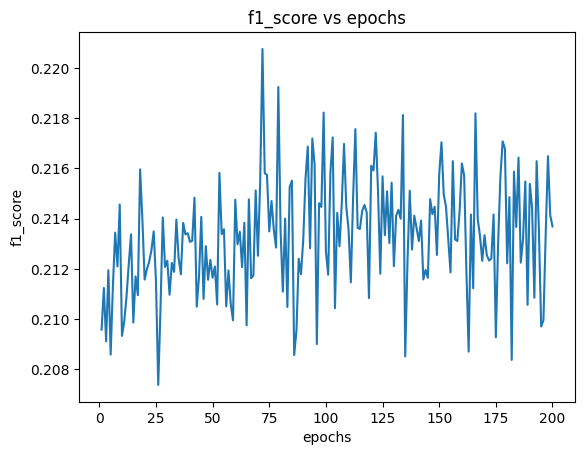

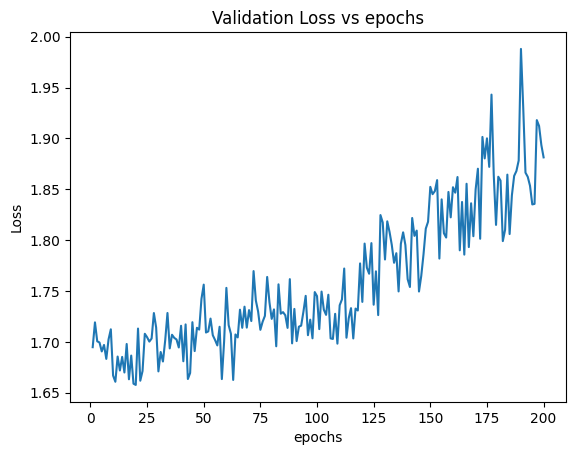

In [12]:
plt.figure(1)
#plt.plot(sorted(list(set(roc_epochs))), f1_arr)
plt.plot(range(1,201), f1_arr)
plt.xlabel("epochs")
plt.ylabel("f1_score")
plt.title('f1_score vs epochs')

plt.figure(2)
#plt.plot(sorted(list(set(roc_epochs))), loss_arr)
plt.plot(range(1,201), loss_arr)
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.title('Validation Loss vs epochs')

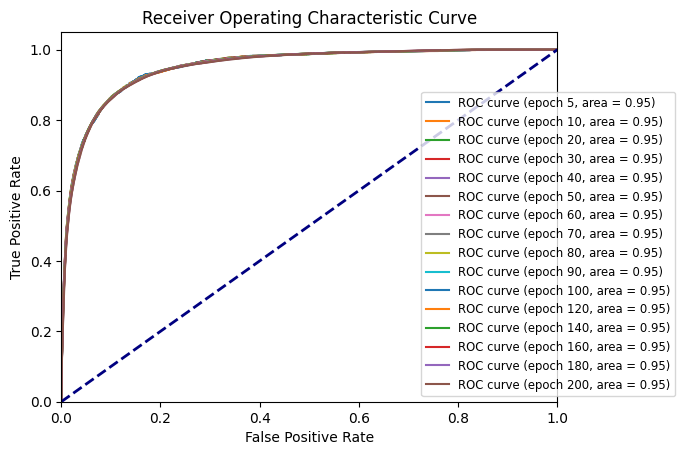

In [13]:
# plot ROC curve
fig2, ax2 = plt.subplots()
for i in range(len(roc_auc)):
    ax2.plot(roc_fpr[i], roc_tpr[i], label=f'ROC curve (epoch {roc_epochs[i]}, area = {roc_auc[i]:.2f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('Receiver Operating Characteristic Curve')
# Set the properties for the legend
legend = ax2.legend(loc='lower right', bbox_to_anchor=(1.25, 0), fontsize='small', framealpha=0.8)